# Detection of Pneumonia through Image classification

## Problem statement: Perform image classification of Chest Xray images to detect Pneumonia

## Downloading the Chest X-Ray Images Data

In [1]:
# For Kaggle
!/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip
!pip install git+https://github.com/Kaggle/kaggle-api.git --upgrade

credentials = {"username":"navyasree","key":"f0fff382b27d8a76a192b7ee80c1d288"}
os.environ['KAGGLE_USERNAME']=credentials["username"]
os.environ['KAGGLE_KEY']=credentials["key"]

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
  Cloning https://github.com/Kaggle/kaggle-api.git to /tmp/pip-req-build-xohu17so
  Running command git clone --filter=blob:none -q https://github.com/Kaggle/kaggle-api.git /tmp/pip-req-build-xohu17so
  Resolved https://github.com/Kaggle/kaggle-api.git to commit 49057db362903d158b1e71a43d888b981dd27159
  Preparing metadata (setup.py) ... done


## Unzip the dataset

In [2]:
# For Kaggle
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia
!unzip chest-xray-pneumonia.zip > /dev/null; echo " done."

100%|█████████████████████████████████████▉| 2.29G/2.29G [00:36<00:00, 86.4MB/s]
100%|██████████████████████████████████████| 2.29G/2.29G [00:36<00:00, 67.6MB/s]
 done.


In [3]:
!rm chest-xray-pneumonia.zip

In [4]:
!sudo ls -R | grep ":$" | sed -e 's/:$//' -e 's/[^-][^\/]*\//--/g' -e 's/^/   /' -e 's/-/|/'

   .
   |-chest_xray
   |---chest_xray
   |-----test
   |-------NORMAL
   |-------PNEUMONIA
   |-----train
   |-------NORMAL
   |-------PNEUMONIA
   |-----val
   |-------NORMAL
   |-------PNEUMONIA
   |---__MACOSX
   |-----chest_xray
   |-------test
   |---------NORMAL
   |---------PNEUMONIA
   |-------train
   |---------NORMAL
   |---------PNEUMONIA
   |-------val
   |---------NORMAL
   |---------PNEUMONIA
   |---test
   |-----NORMAL
   |-----PNEUMONIA
   |---train
   |-----NORMAL
   |-----PNEUMONIA
   |---val
   |-----NORMAL
   |-----PNEUMONIA
   |-log
   |---train
   |-----plugins
   |-------profile
   |---------2022_06_18_20_43_17
   |---------2022_06_18_20_56_34
   |---validation
   |-logs
   |---train
   |-----plugins
   |-------profile
   |---------2022_06_19_04_09_22
   |---validation
   |-lost+found


## Importing the packages

In [5]:
# Importing the packages
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf

In [6]:
tf.__version__

'2.3.4'

In [7]:
import random
import cv2

## Reading/Batch Processing the images

In [8]:
batch_size=8
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1/255,vertical_flip=True, 
      horizontal_flip=True,
      rotation_range=0.4)
test_datagen=tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255.)

In [9]:
train_generator = train_datagen.flow_from_directory(
        'chest_xray/train',
        target_size=(128, 128),
        batch_size=batch_size,
        #color_mode='grayscale',
        class_mode='categorical')

test_generator = test_datagen.flow_from_directory(
        'chest_xray/test',
        target_size=(128, 128),
        batch_size=batch_size,
        #color_mode='grayscale',
        class_mode='categorical')

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


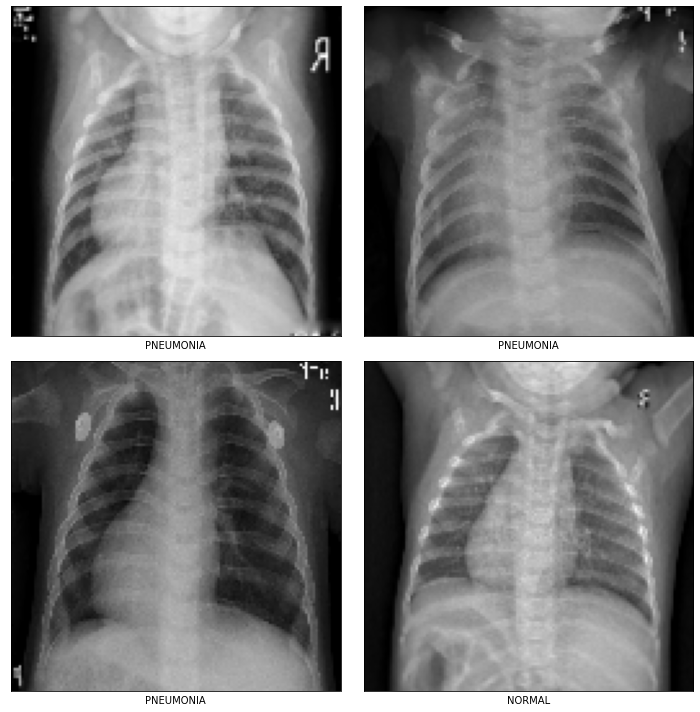

In [11]:
x,y = train_generator.next()

keys = train_generator.class_indices.keys()

plt.figure(figsize=(10,10))
for i in range(4):
  plt.subplot(2,2,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  image = x[i]
  label = y[i]
  index = np.argmax(label)
  plt.imshow(image, cmap = plt.cm.binary)
  plt.xlabel(list(keys)[index])

plt.tight_layout()
plt.show()

## Building the model

In [12]:
# clear the current tensorflow graph and create new one
tf.keras.backend.clear_session()

# call the inception imagenet pretrained model
model_imagenet = tf.keras.applications.InceptionV3(weights='imagenet',include_top=False, input_shape=(128,128,3))
last_layer = model_imagenet.output

In [13]:
# freeze the weights of the model
for layer in model_imagenet.layers:
	layer.trainable = False

In [14]:
last_layer

<tf.Tensor 'mixed10/concat:0' shape=(None, 2, 2, 2048) dtype=float32>

In [15]:
### Flatten the last layer
x = tf.keras.layers.Flatten()(last_layer)
#x = x(last_layer)
x = tf.keras.layers.Dropout(0.1)(x)

# add fully-connected & dropout layers
x = tf.keras.layers.Dense(128, activation='relu')(x)   ##try with larger number of neurons 
x = tf.keras.layers.Dense(64, activation='relu')(x)   ##try with larger number of neurons

x = tf.keras.layers.Dropout(0.3)(x)

n_classes=train_generator.num_classes
# a softmax layer for 2 classes
out_layer = tf.keras.layers.Dense(n_classes, activation='softmax')(x)

# this is the model we will train
model = tf.keras.Model(inputs=model_imagenet.input, outputs=out_layer)

In [16]:
len(model.layers)

317

In [17]:
# from tensorflow.keras.optimizers import Adam
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [18]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 63, 63, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 63, 63, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 63, 63, 32)   0           batch_normalization[0][0]        
_______________________________________________________________________________________

## Training the model

In [19]:
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping

batch_size = 32

	
es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=3)

fitted_model = model.fit(
        train_generator,
        steps_per_epoch= int(train_generator.samples) // batch_size,
        epochs=300,     
        validation_data=test_generator,
        validation_steps= int(test_generator.samples) // batch_size,        
        callbacks=[es])

Epoch 1/300
163/163 [==============================] - 36s 220ms/step - loss: 0.8271 - accuracy: 0.8459 - val_loss: 0.9430 - val_accuracy: 0.7303
Epoch 2/300
163/163 [==============================] - 34s 206ms/step - loss: 0.3587 - accuracy: 0.8811 - val_loss: 0.7205 - val_accuracy: 0.7368
Epoch 3/300
163/163 [==============================] - 34s 206ms/step - loss: 0.2131 - accuracy: 0.9233 - val_loss: 1.1227 - val_accuracy: 0.7171
Epoch 4/300
163/163 [==============================] - 34s 208ms/step - loss: 0.2020 - accuracy: 0.9164 - val_loss: 0.7315 - val_accuracy: 0.7171
Epoch 5/300
163/163 [==============================] - 34s 206ms/step - loss: 0.1937 - accuracy: 0.9202 - val_loss: 0.5140 - val_accuracy: 0.7368
Epoch 00005: early stopping


## Save the trained model

In [20]:
model.save('xray_model_tf1.h5')

## Model Prediction

In [21]:
def predict_image(model,image_file_name):
  
  classifier=model

  img = tf.keras.preprocessing.image.load_img(image_file_name,target_size=(128, 128))
  img_arr = tf.keras.preprocessing.image.img_to_array(img)/255

  x=img_arr.reshape(1, 128, 128, 3)
  plt.imshow(img)

  result = classifier.predict(x)
  print(list(train_generator.class_indices.keys())[list(train_generator.class_indices.values()).index(np.argmax(result))])

PNEUMONIA


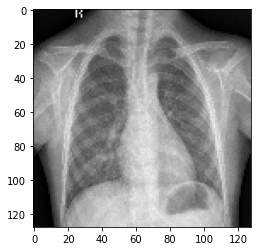

In [22]:
predict_image(model,'/home/ec2-user/SageMaker/chest_xray/test/NORMAL/IM-0010-0001.jpeg')

PNEUMONIA


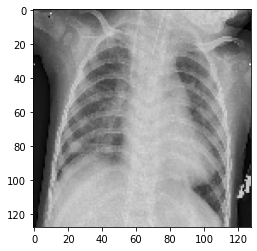

In [23]:
predict_image(model,'/home/ec2-user/SageMaker/chest_xray/test/PNEUMONIA/person101_bacteria_484.jpeg')

NORMAL


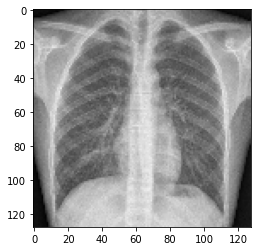

In [24]:
predict_image(model,'/home/ec2-user/SageMaker/chest_xray/test/NORMAL/IM-0043-0001.jpeg')

PNEUMONIA


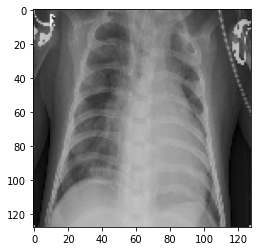

In [25]:
predict_image(model,'/home/ec2-user/SageMaker/chest_xray/test/PNEUMONIA/person136_bacteria_650.jpeg')

## Evaluate the model performance

In [26]:
#!pip3 install -U scikit-learn
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [27]:
def assess_model(model):
    predicted_vals = np.argmax(model.predict(test_generator, steps = len(test_generator)),axis=1)
    
    accuracy = tf.keras.metrics.binary_accuracy(test_generator.labels, predicted_vals)
    print('Accuracy: %f' % accuracy)
    print(classification_report(test_generator.labels, predicted_vals))
    print('Confusion matrix')
    cm = confusion_matrix(y_true=test_generator.labels, y_pred=predicted_vals)
    print(cm)

In [28]:
# assess the model performance

assess_model(model)

Accuracy: 0.584936
              precision    recall  f1-score   support

           0       0.40      0.22      0.29       234
           1       0.63      0.80      0.71       390

    accuracy                           0.58       624
   macro avg       0.52      0.51      0.50       624
weighted avg       0.55      0.58      0.55       624

Confusion matrix
[[ 52 182]
 [ 77 313]]
